#### Libraries

In [2]:
import sys
import robin_stocks.robinhood as r
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode
import importlib
import yfinance as yf
import datapackage
import time
import webbrowser


from IPython.display import Markdown
def printmd(string):
    display(Markdown(string))

    
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 1000)


In [3]:
import inspect
lines = inspect.getsource(go.Figure.update_layout)
print(lines)

    def update_layout(self, dict1=None, overwrite=False, **kwargs):
        """
        Update the properties of the figure's layout with a dict and/or with
        keyword arguments.

        This recursively updates the structure of the original
        layout with the values in the input dict / keyword arguments.

        Parameters
        ----------
        dict1 : dict
            Dictionary of properties to be updated
        overwrite: bool
            If True, overwrite existing properties. If False, apply updates
            to existing properties recursively, preserving existing
            properties that are not specified in the update operation.
        kwargs :
            Keyword/value pair of properties to be updated

        Returns
        -------
        BaseFigure
            The Figure object that the update_layout method was called on
        """
        self.layout.update(dict1, overwrite=overwrite, **kwargs)
        return self



In [6]:
import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
import pandas as pd
import numpy as np
import tickers_graphing_module as tg
import analysis_module as am
import analytics_functions as af
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import importlib
import bokeh
import param
import io
importlib.reload(am)
importlib.reload(tg)
importlib.reload(af)

raw_css = """
.bk-root .bk-tabs-header.bk-above .bk-headers, .bk-root .bk-tabs-header.bk-below .bk-headers{
font-size:16px;
}
"""


pn.extension('plotly', raw_css=[raw_css])

button = pn.widgets.Button(name='Get Ticker Stats and Financials', button_type='primary')
text = pn.widgets.TextInput(name = 'Ticker', value='TSLA')
def b(event):
    af.get_share_stats_and_financials(text.value)
    
    
button2 = pn.widgets.Button(name='Swaggy Stocks', button_type='primary')
def c(event):
    af.swaggy_stocks()


button3 = pn.widgets.Button(name='Get Options Chain', button_type='primary')
text3 = pn.widgets.TextInput(name = 'Options Chain Ticker', value='TSLA')
def d(event):
    af.get_options_chain(text3.value)
    
    
button4 = pn.widgets.Button(name='Top Shorted Stocks', button_type='primary')
def e(event):
    af.get_top_shorted_stocks()



button.on_click(b)
button2.on_click(c)
button3.on_click(d)
button4.on_click(e)
actions = pn.Column(text, button, pn.Spacer(height = 5), text3, button3, pn.Spacer(height = 5), button2, pn.Spacer(height = 5), button4, name = 'Get Info')




class Charts(param.Parameterized):

    ticker = param.String(default="TSLA", doc="Ticker symbol")

    start_date = param.String(default="2021-01-01", doc="Start Date")
    
    end_date = param.String(default="2022-12-31", doc="End Date")
    
    moving_average = param.ObjectSelector(default="yes", objects=["yes", "no"])
    
    moving_average_days = param.Integer(10, bounds=(1, 365))

    @param.depends('ticker', 'start_date', 'end_date', 'moving_average', 'moving_average_days')
    def linechart(self):
        return pn.panel(tg.line_chart(self.ticker, start = self.start_date, end = self.end_date, moving_avg = self.moving_average, moving_avg_days = self.moving_average_days))
    
    def candlestick(self):
        return pn.panel(tg.candlestick_chart(self.ticker, start = self.start_date, end = self.end_date, moving_avg = self.moving_average, moving_avg_days = self.moving_average_days))
        
    
charts_class = Charts(name='Line, Candlestick Charts, and Info')

charts_and_info = pn.Column(charts_class.param, charts_class.linechart, charts_class.candlestick, name = 'Charts and Info')



class Analyze_trades(param.Parameterized):
    
    
    file_input = param.Parameter()
    data = param.DataFrame()
    
    def __init__(self, **params):
        super().__init__(file_input=pn.widgets.FileInput(accept='.csv,.xlsx,.xls'), **params)
        self.df_pane = pn.pane.DataFrame(width=1000, max_rows = 10)
        self.df_pane2 = pn.pane.DataFrame(width=1000, max_rows = 10)
        self.total_gain = pn.indicators.Number(name='Total Realized Gain', format='${value}', font_size = '30pt')
        self.total_loss = pn.indicators.Number(name='Total Realized Loss', format='${value}', font_size = '30pt')

    @param.depends("file_input.value", watch=True)
    def parse_file_input(self):
        value = self.file_input.value
        if value:
            string_io = io.StringIO(value.decode("utf8"))
            self.data = af.preprocess_rh_stock_orders(string_io)
            
        else:
            print("error")

    @param.depends('data', watch=True)
    def get_df(self):
        self.df_pane.object = self.data

        trades = af.Stocks(self.data)
        trades.examine_trades()
        
        self.df_pane2.object = trades.trades_df
        self.total_gain.value = round(trades.total_gain)
        self.total_loss.value = round(trades.total_loss)

    def view(self):
        return pn.Column(
            "## Upload and process data",
            
            self.file_input,
            pn.layout.Divider(),
            self.total_gain,
            self.total_loss,
            self.df_pane,
            pn.Spacer(height = 500),
            self.df_pane2,
            name = "Analyze Trades"
        )

analyze_trades_view = Analyze_trades().view()



class ExamineCharts(param.Parameterized):
    
    file_input = param.Parameter()
    select_stock=pn.widgets.Select(name = 'Select Stock', options = [])
    data = param.DataFrame()
    chart = pn.pane.Plotly()
    chart2 = pn.pane.Plotly()
    start_date_input = pn.widgets.TextInput(name='Optional Start Date', placeholder='Enter start date (optional)')
    end_date_input = pn.widgets.TextInput(name='Optional End Date', placeholder='Enter end date (optional)')
    
    def __init__(self, **params):
        super().__init__(file_input=pn.widgets.FileInput(accept='.csv,.xlsx,.xls'), **params)
        
    
    @param.depends("file_input.value", watch=True)
    def parse_file_input(self):
        value = self.file_input.value
        if value:
            string_io = io.StringIO(value.decode("utf8"))
            self.data = af.preprocess_rh_stock_orders(string_io)
            
        else:
            print("error")
    
    @param.depends('data', watch = True)
    def refresh_symbols(self):
        self.select_stock.options = sorted(list(self.data.symbol.unique()))
        
        
    @param.depends('data', 'select_stock.value', 'start_date_input.value', 'end_date_input.value', watch = True)
    def plotting(self):
        trades = af.Stocks(self.data)
        trades.examine_trades()
        
        if self.select_stock.value:
            self.chart.object = tg.plot_buysell_points_line(self.select_stock.value, tradesdf = trades.trades_df, start_date = self.start_date_input.value,
                                                      end_date= self.end_date_input.value)
            
            self.chart2.object = tg.plot_buysell_points_candlestick(self.select_stock.value, tradesdf = trades.trades_df, start_date = self.start_date_input.value,
                                                      end_date= self.end_date_input.value)
        else:
            print('select stock')
    
    
    def view(self):
        return pn.Column(
            "## Examine Charts",
            self.file_input,
            self.select_stock,
            self.start_date_input,
            self.end_date_input,
            pn.layout.Divider(),
            self.chart2,
            pn.Spacer(height = 150),
            self.chart,
            name = "Examine Charts"
        )

examine_charts_view = ExamineCharts().view()



tabs = pn.Tabs(actions, charts_and_info, analyze_trades_view, examine_charts_view)
tabs


ModuleNotFoundError: No module named 'bokeh.core.serialization'

Tabs
    [0] Column(name='Get Info')
        [0] TextInput(name='Ticker', value='TSLA')
        [1] Button(button_type='primary', name='Get Ticker Stats a...)
        [2] Spacer(height=5)
        [3] TextInput(name='Options Chain Ticker', value='TSLA')
        [4] Button(button_type='primary', name='Get Options Chain')
        [5] Spacer(height=5)
        [6] Button(button_type='primary', name='Swaggy Stocks')
        [7] Spacer(height=5)
        [8] Button(button_type='primary', name='Top Shorted Stocks')
    [1] Column(name='Charts and Info')
        [0] Column(margin=5, name='Line, Candlestick Charts,..., width=300)
            [0] StaticText(value='<b>Line, Candlestick Char...)
            [1] TextInput(name='Ticker', value='TSLA')
            [2] TextInput(name='Start date', value='2021-01-01')
            [3] TextInput(name='End date', value='2022-12-31')
            [4] Select(name='Moving average', options=OrderedDict([('yes', ...]), value='yes')
            [5] IntSlider(end=3

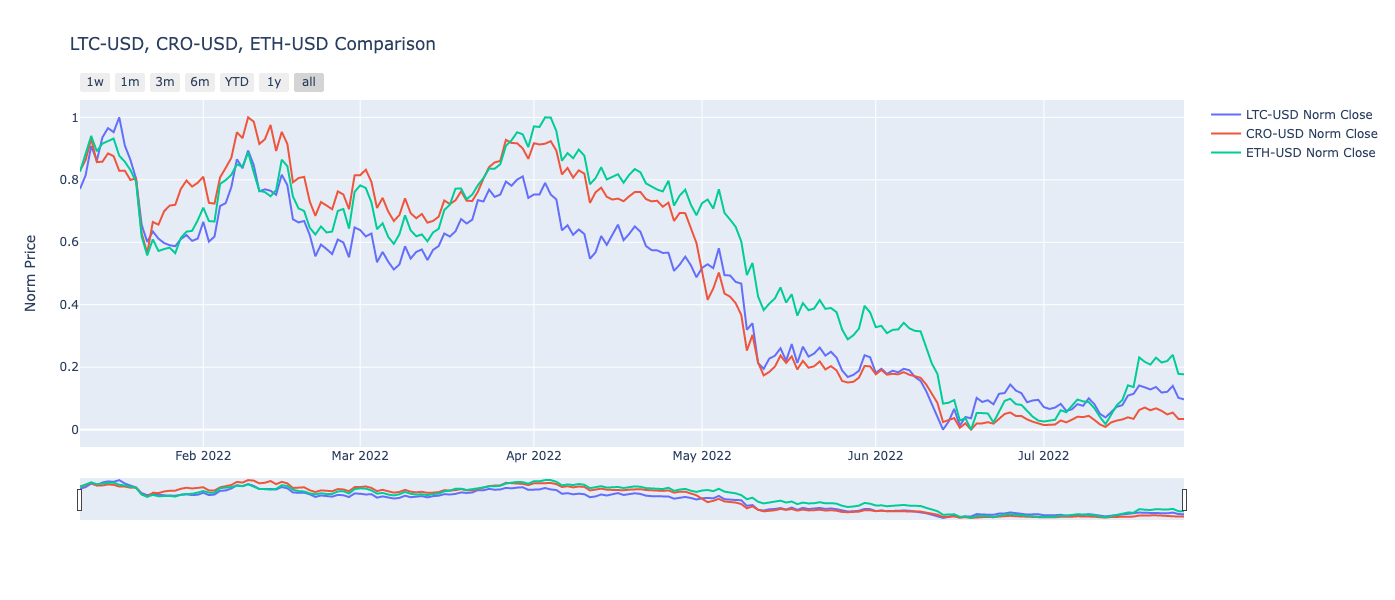

Given Timeframe:

LTC-USD Return: -57.59%

CRO-USD Return: -72.94%

ETH-USD Return: -53.24%

Last 90 Days Close Pearson Correlation Matrix: 

,LTC-USD,CRO-USD,ETH-USD
LTC-USD,1.000000,0.963071,0.960145
CRO-USD,0.963071,1.000000,0.956059
ETH-USD,0.960145,0.956059,1.000000


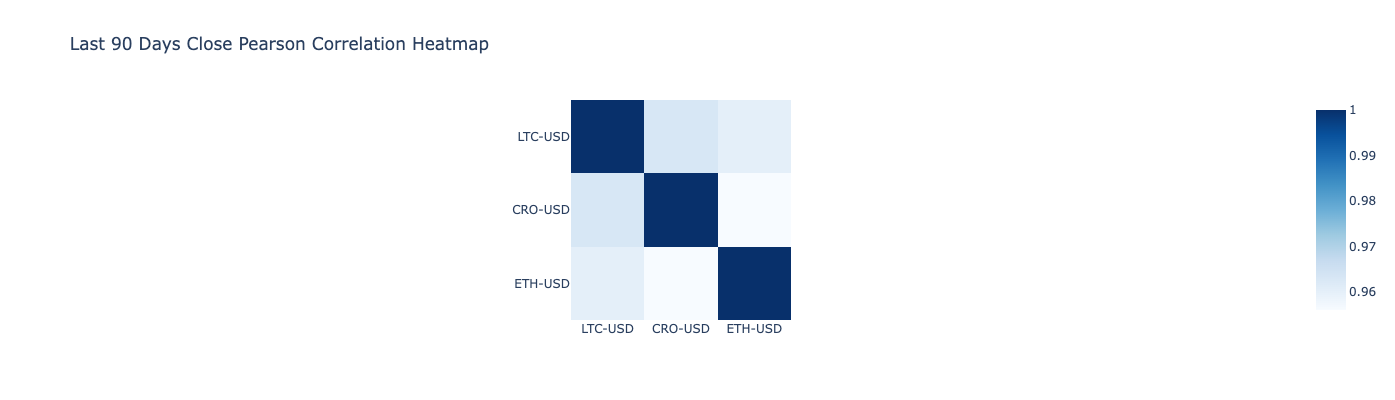

In [94]:
tg.compare_charts(['LTC-USD', 'CRO-USD', 'ETH-USD'], start = '2022-01-10', end = '2022-12-31')

# Stocks trade history

#### Examine stock trades

In [25]:
stocks.examine_trades()
stocks.add_price_diff()


Total runtime:  0.06 s
- AABA: No data found, symbol may be delisted
- WORK: No data found, symbol may be delisted
- IPOE: No data found, symbol may be delisted
- APTI: No data found for this date range, symbol may be delisted
- MZOR: No data found for this date range, symbol may be delisted

Total runtime:  14.32 s


### Analyzing hold time

In [159]:
stocks.add_hold_time()


Total runtime:  0.18 s


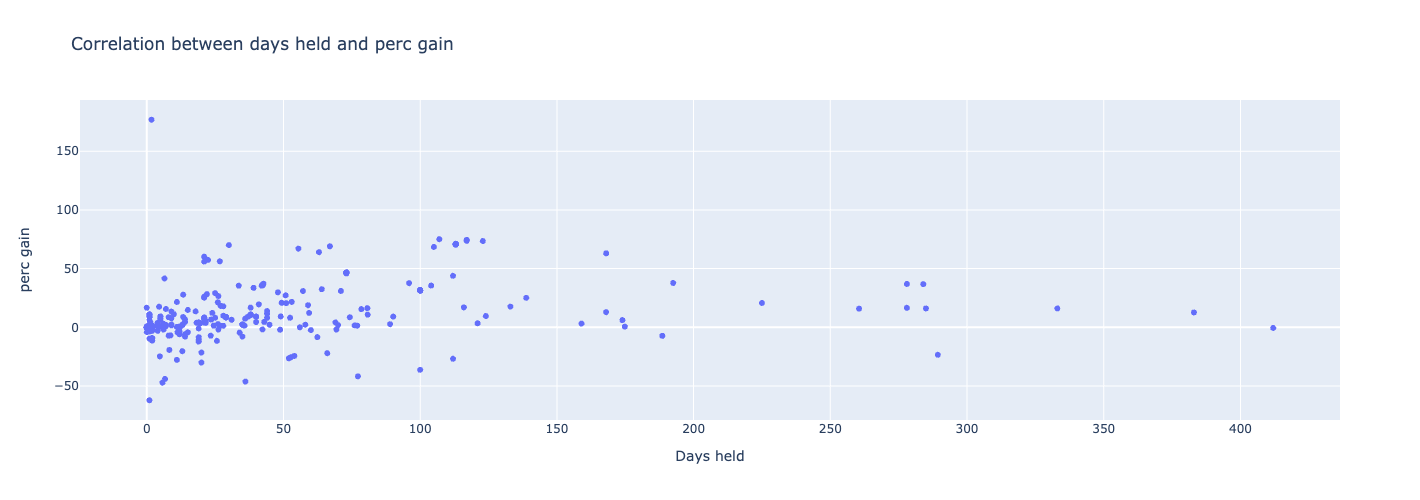

Pearson Correlation: 0.25

In [28]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = sells['Days Held'], y = sells['Perc gain'], mode = 'markers', text = sells['Symbol']))

fig2.update_layout(title = 'Correlation between days held and perc gain', xaxis_title = 'Days held', yaxis_title = 'perc gain', width = 1000, height = 500)



fig2.show()

printmd("Pearson Correlation: " + str(round(sells['Days Held'].corr(sells['Perc gain']),3)))
print()

### Options trade history

In [30]:
r.export.export_completed_option_orders(dir_path = '.', file_name = 'My_option_orders.csv')
options = pd.read_csv('My_option_orders.csv')
options['order_created_at'] = options['order_created_at'].replace('T(.*)', '', regex=True)
options['order_created_at'] = pd.to_datetime(options['order_created_at'], format = '%Y-%m-%d')
options['expiration_date'] = pd.to_datetime(options['expiration_date'], format = '%Y-%m-%d')
options = options.iloc[::-1].reset_index(drop=True)

#correcting GME order glitch for one contract @ 20.5 strike
insert_order = pd.DataFrame(options.iloc[34].copy()).T
insert_order['price'], insert_order['processed_quantity'] = 0.09, 1

options1 = options.iloc[0:35]
options2 = options.iloc[35:]

option_orders = pd.concat([options1, insert_order, options2]).reset_index(drop=True)

Found Additional pages.
Loading page 2 ...
Loading page 3 ...
Loading page 4 ...


#### Examine option trades

In [68]:
options = et.Options(option_orders)

options.examine_trades()

In [71]:
options.trades_df.head(10)

,Side,Symbol,Option Type,Strategy,Expiration,Strike,Date,Quantity,Avg_Price,Cur_Avg_Cost,Cur Quantity,Total,Gain,% Gain,Expired,Net Gain/Loss
0,buy,WORK,call,long_call,2020-07-17,48.0,2020-06-09,1.0,0.20,0.20,1.0,20.0,0.0,0,,0.0
1,buy,MA,call,long_call,2020-07-10,332.5,2020-06-11,1.0,2.52,2.52,1.0,252.0,0.0,0,,0.0
2,buy,SOXL,call,long_call,2020-07-17,260.0,2020-06-11,1.0,2.00,2.00,1.0,200.0,0.0,0,,0.0
3,buy,UVXY,put,long_put,2020-06-26,31.5,2020-06-12,1.0,2.20,2.20,1.0,220.0,0.0,0,,0.0
4,buy,WB,put,long_put,2020-07-31,29.0,2020-06-15,1.0,0.95,0.95,1.0,95.0,0.0,0,,0.0
5,buy,DIS,call,long_call,2020-07-24,165.0,2020-06-19,4.0,0.12,0.12,4.0,48.0,0.0,0,,0.0
6,buy,DAL,call,long_call,2020-08-21,55.0,2020-06-19,2.0,0.33,0.33,2.0,66.0,0.0,0,,0.0
7,sell,SOXL,call,long_call,2020-07-17,260.0,2020-06-22,1.0,2.40,2.00,0.0,240.0,40.0,20.0%,,40.0
8,sell,UVXY,put,long_put,2020-06-26,31.5,2020-06-25,1.0,0.24,2.20,0.0,24.0,-196.0,-89.09%,,-156.0
9,buy,AA,put,long_put,2020-07-31,11.0,2020-07-02,1.0,0.94,0.94,1.0,94.0,0.0,0,,-156.0


#### Crypto trade history

In [80]:
#get all crypto orders
crypto_orders = pd.DataFrame(r.orders.get_all_crypto_orders(info=None))[['average_price', 'created_at', 'cumulative_quantity', 'currency_pair_id', 'rounded_executed_notional', 'side', 'state', 'type']]
crypto_orders.columns = ['average_price', 'date', 'quantity', 'currency_pair_id', 'total', 'side', 'state', 'type']
crypto_orders = crypto_orders[crypto_orders['state'] != 'canceled']

crypto_orders['date'] = crypto_orders['date'].replace('T(.*)', '', regex=True)
crypto_orders['date'] = pd.to_datetime(crypto_orders['date'], format = '%Y-%m-%d')
crypto_orders['average_price'] = crypto_orders['average_price'].astype(float)
crypto_orders['quantity'] = crypto_orders['quantity'].astype(float)
crypto_orders['total'] = crypto_orders['total'].astype(float)

currencies_info = pd.DataFrame(r.markets.get_currency_pairs(info='asset_currency'))[['code', 'id', 'name', 'type']]
currency_pair_ids = pd.DataFrame(r.markets.get_currency_pairs(info='id')).rename(columns = {0: 'currency_pair_id'})
currencies_info = pd.concat([currencies_info, currency_pair_ids], axis=1)
currencies_info = currencies_info[['code', 'currency_pair_id']].rename(columns = {'code':'symbol'})

crypto_orders = crypto_orders.merge(currencies_info, how = 'left', on = 'currency_pair_id')

crypto_orders = crypto_orders.iloc[::-1].dropna(subset = ['average_price']).reset_index(drop=True)


crypto_buyorders, crypto_sellorders = crypto_orders[crypto_orders['side'] == 'buy'], crypto_orders[crypto_orders['side'] == 'sell']

Found Additional pages.
Loading page 2 ...


#### Examine crypto trades

In [82]:
crypto = et.StocksCrypto(crypto_orders, crypto = 'yes')
crypto.examine_trades()
# crypto.add_price_diff()  

In [22]:
crypto.gains_df

,Side,Symbol,Date,Quantity,Avg_Price,Cur Quantity,Cur_Avg_Cost,Total,Gain,% Gain,Net Gain/Loss,Free/Acquired Stock
0,sell,ETH,2021-01-10,16.71,1216.41,0.00,1023.89,20327.87,3217.36,18.8%,3219.27,
1,sell,LTC,2021-05-04,7.56,335.00,0.00,202.64,2531.57,1000.29,65.32%,4705.15,
2,sell,ETH,2021-01-30,2.00,1369.11,0.00,1231.11,2738.21,276.00,11.21%,3608.98,
3,sell,ETH,2021-01-29,1.00,1357.52,2.05,1231.11,1357.52,126.41,10.27%,3325.74,
4,sell,DOGE,2021-05-04,365.00,0.55,0.00,0.27,202.45,102.75,103.05%,3704.86,
5,sell,DOGE,2021-01-29,15470.00,0.08,0.00,0.07,1160.76,76.10,7.02%,3199.33,
6,sell,ETH,2021-01-29,0.05,1369.08,2.00,1231.11,71.87,7.24,11.21%,3332.98,
7,sell,ETH,2021-01-26,0.08,1317.97,3.05,1231.11,99.95,6.59,7.06%,3123.23,
8,sell,ETH,2021-01-11,1.00,1103.00,0.00,1100.85,1103.00,2.15,0.2%,3221.42,
9,sell,DOGE,2021-02-26,2187.00,0.06,0.00,0.05,120.94,1.24,1.04%,3602.11,


### Total Gain/Loss

In [36]:

total_gain = round(stocks.total_gain + crypto.total_gain + options.total_optionsgain, 2)
total_loss = round(stocks.total_loss + crypto.total_loss + options.total_optionsloss, 2)
net_gain_loss = round(total_gain + total_loss,2)

print(f'Total stock gain, loss: $ {round(stocks.total_gain,2)}, $ {round(stocks.total_loss,2)}')
print(f'Total crypto gain, loss: $ {round(crypto.total_gain,2)}, $ {round(crypto.total_loss,2)}')
print(f'Total option gain, loss: $ {round(options.total_optionsgain,2)}, $ {round(options.total_optionsloss,2)}')
print(f'Total gain: $ {total_gain}')
print(f'Total loss: $ {total_loss}')
print(f'Net Gain/Loss: $ {net_gain_loss}')
print()

Total stock gain, loss: $ 27749.08, $ -9661.97
Total crypto gain, loss: $ 3819.15, $ -114.29
Total option gain, loss: $ 9434.0, $ -14606.0
Total gain: $ 41002.23
Total loss: $ -24382.26
Net Gain/Loss: $ 16619.97



## Schwab

In [111]:
#parents1
parents1_schwaborders = pd.read_csv('Parents1_Schwab.csv', header=1, skipfooter=1, engine = 'python').drop('Unnamed: 8', axis=1)
parents1_schwaborders['Date'] = pd.to_datetime(parents1_schwaborders['Date'], format = '%m/%d/%Y')
parents1_schwaborders['Price'] = parents1_schwaborders['Price'].apply(lambda x: x.strip()[1:].replace(',', '')).astype(float)
parents1_schwaborders['Action'] = parents1_schwaborders['Action'].apply(lambda x: x.replace('Buy', 'buy') if x == 'Buy' else 'sell')
parents1_schwaborders.columns = ['date', 'side', 'symbol', 'description', 'quantity', 'average_price', 'fees & comm', 'amount']
parents1_schwaborders['amount'] = parents1_schwaborders['amount'].str.replace('[$,()]', '', regex = True).astype('float64')
parents1_schwaborders = parents1_schwaborders.rename(columns = {'amount':'total'}).iloc[::-1].reset_index(drop=True)



parents1_stocks = et.StocksCrypto(parents1_schwaborders)

parents1_stocks.examine_trades()
parents1_stocks.add_price_diff()



# parents1_stocks.trades_df.drop(columns = 'Free/Acquired Stock').to_excel('Parents1 Schwab Trades.xlsx')
# parents1_stocks.gains_df.to_excel('Parents1 Schwab Trades Gainers.xlsx')
# parents1_stocks.losses_df.to_excel('Parents1 Schwab Trades Losers.xlsx')

In [586]:
df = parents1_stocks.trades_df_with_price_diff.copy()


for i in range(len(df)):

    transac_date = pd.to_datetime(df.loc[i, 'Date'])
    symbol = df.loc[i, 'Symbol']

    if symbol == 'SOXL' and transac_date < pd.to_datetime('2021-03-02'):
        df.loc[i, 'Avg_Price'] /= 15

    if symbol == 'TECL' and transac_date < pd.to_datetime('2021-03-02'):
        df.loc[i, 'Avg_Price'] /= 10

    if symbol == 'AAPL' and transac_date < pd.to_datetime('2020-08-28'):
        df.loc[i, 'Avg_Price'] /= 4

    if symbol == 'TSLA' and transac_date < pd.to_datetime('2020-08-31'):
        df.loc[i, 'Avg_Price'] /= 5

In [78]:
#parents2
parents2_schwaborders = pd.read_csv('Parents2_Schwab.csv', header=1, skipfooter=1, engine = 'python').drop('Unnamed: 8', axis=1)
parents2_schwaborders['Date'] = pd.to_datetime(parents2_schwaborders['Date'], format = '%m/%d/%Y')
parents2_schwaborders['Price'] = parents2_schwaborders['Price'].apply(lambda x: x.strip()[1:].replace(',', '')).astype(float)
parents2_schwaborders['Action'] = parents2_schwaborders['Action'].apply(lambda x: x.replace('Buy', 'buy') if x == 'Buy' else 'sell')
parents2_schwaborders.columns = ['date', 'side', 'symbol', 'description', 'quantity', 'average_price', 'fees & comm', 'amount']
parents2_schwaborders['amount'] = parents2_schwaborders['amount'].str.replace('[$,()]', '').astype('float64')
parents2_schwaborders = parents2_schwaborders.rename(columns = {'amount':'total'}).iloc[::-1].reset_index(drop=True)




parents2_stocks = StocksCrypto(parents2_schwaborders)

parents2_stocks.examine_trades()
parents2_stocks.get_gainers_losers()
parents2_stocks.get_examined_trades_df()

display(parents2_stocks.trades_df)
display(parents2_stocks.gains_df)
display(parents2_stocks.losses_df)

# parents2_stocks.trades_df.drop(columns = 'Free/Acquired Stock').to_excel('Parents1 Schwab Trades.xlsx')
# parents2_stocks.gains_df.to_excel('Parents1 Schwab Trades Gainers.xlsx')
# parents2_stocks.losses_df.to_excel('Parents1 Schwab Trades Losers.xlsx')

Sell GME on 2021-01-29, Quantity: 6, Avg Price: $260.95, Current Avg Cost: 335.0, Total: $1565.67
Gain: $-444.3, % Gain: -22.1%, LOSS
Net Gain/Loss: $-444.3


Sell GME on 2021-01-29, Quantity: 5, Avg Price: $260.95, Current Avg Cost: 335.0, Total: $1304.72
Gain: $-370.25, % Gain: -22.1%, LOSS
Net Gain/Loss: $-814.55


Sell NCLH on 2021-02-05, Quantity: 21, Avg Price: $24.733, Current Avg Cost: 22.39, Total: $519.38
Gain: $49.29, % Gain: 10.49%
Net Gain/Loss: $-765.26


Sell RCL on 2021-02-08, Quantity: 16, Avg Price: $70.802, Current Avg Cost: 65.65, Total: $1132.8
Gain: $82.43, % Gain: 7.85%
Net Gain/Loss: $-682.83


Sell UAL on 2021-02-08, Quantity: 21, Avg Price: $44.2711, Current Avg Cost: 40.04, Total: $929.67
Gain: $88.94, % Gain: 10.58%
Net Gain/Loss: $-593.89


Sell NCLH on 2021-02-12, Quantity: 46, Avg Price: $23.4519, Current Avg Cost: 22.39, Total: $1078.77
Gain: $49.05, % Gain: 4.76%
Net Gain/Loss: $-544.84


Sell PLUG on 2021-02-19, Quantity: 23, Avg Price: $55.38, Current

,Side,Symbol,Date,Quantity,Avg_Price,Cur_Avg_Cost,Total,Gain,% Gain,Net Gain/Loss,Free/Acquired Stock
0,buy,PLUG,2021-01-26,16,73.59,73.59,-1177.44,0.00,0%,0.00,
1,buy,GME,2021-01-28,11,335.00,335.00,-3685.00,0.00,0%,0.00,
2,sell,GME,2021-01-29,6,260.95,335.00,1565.67,-444.30,-22.1%,-444.30,
3,sell,GME,2021-01-29,5,260.95,335.00,1304.72,-370.25,-22.1%,-814.55,
4,buy,AAL,2021-02-01,65,16.92,16.92,-1099.80,0.00,0%,-814.55,
5,buy,NCLH,2021-02-01,67,22.39,22.39,-1499.84,0.00,0%,-814.55,
6,buy,UAL,2021-02-01,37,40.04,40.04,-1481.32,0.00,0%,-814.55,
7,buy,JBLU,2021-02-01,70,14.41,14.41,-1008.41,0.00,0%,-814.55,
8,buy,RCL,2021-02-01,16,65.65,65.65,-1050.40,0.00,0%,-814.55,
9,buy,PLUG,2021-02-01,2,63.52,72.47,-127.03,0.00,0%,-814.55,


,Symbol,Date,Quantity,Avg_Price,Gain,% Gain
0,AAL,2021-02-25,135,21.0114,519.26,22.41%
1,UPST,2021-03-18,46,89.1201,372.96,10.01%
2,JBLU,2021-02-23,88,19.1000,370.82,28.31%
3,UAL,2021-02-26,16,53.0600,208.39,32.53%
4,SAVE,2021-02-23,21,38.1200,163.20,25.61%
5,UAL,2021-02-08,21,44.2711,88.94,10.58%
6,RCL,2021-02-08,16,70.8020,82.43,7.85%
7,NCLH,2021-02-05,21,24.7330,49.29,10.49%
8,NCLH,2021-02-12,46,23.4519,49.05,4.76%
9,SAVE,2021-02-23,5,38.1200,38.86,25.61%


,Symbol,Date,Quantity,Avg_Price,Gain,% Gain
0,GME,2021-01-29,6,260.95,-444.30,-22.1%
1,GME,2021-01-29,5,260.95,-370.25,-22.1%
2,PLUG,2021-02-19,23,55.38,-348.18,-21.47%


In [105]:
#grandpa

grandpa_schwab = pd.read_csv('Grandpa_Schwab.csv', header=1, skipfooter=1, engine = 'python').drop('Unnamed: 8', axis=1)
grandpa_schwab['Date'] = pd.to_datetime(grandpa_schwab['Date'], format = '%m/%d/%Y')
grandpa_schwab['Price'] = grandpa_schwab['Price'].apply(lambda x: x.strip()[1:].replace(',', '')).astype(float)
grandpa_schwab.columns = ['date', 'side', 'symbol', 'description', 'quantity', 'average_price', 'fees & comm', 'amount']
grandpa_schwab['amount'] = grandpa_schwab['amount'].str.replace('[$,()]', '').astype('float64')
grandpa_schwab = grandpa_schwab.rename(columns = {'amount':'total'}).iloc[::-1].reset_index(drop=True)


grandpa_schwab_stocks = grandpa_schwab[~grandpa_schwab['description'].str.contains('PUT') & ~grandpa_schwab['description'].str.contains('CALL')].reset_index(drop=True)
grandpa_schwab_stocks['side'] = grandpa_schwab_stocks['side'].apply(lambda x: 'buy' if x == 'Buy' else 'sell')


grandpa_schwab_options = grandpa_schwab[grandpa_schwab['description'].str.contains('PUT') | grandpa_schwab['description'].str.contains('CALL')].reset_index(drop=True)

def replace_action(item):
    if item == 'Buy to Open':
        return 'buy'
        
    elif item == 'Sell to Close':
        return 'sell'
        
    elif item == 'Sell to Open':
        return 'sell'
    
    elif item == 'Buy to Close':
        return 'buy'


grandpa_schwab_options['side'] = grandpa_schwab_options['side'].apply(replace_action)


grandpa_schwab_options[['symbol', 'expiration_date', 'strike_price','option_type']] = grandpa_schwab_options['symbol'].str.split(expand=True) 
grandpa_schwab_options['expiration_date'] = pd.to_datetime(grandpa_schwab_options['expiration_date'], format = '%m/%d/%Y')
grandpa_schwab_options['option_type'] = grandpa_schwab_options['option_type'].apply(lambda x: 'Put' if x == 'P' else 'Call')
grandpa_schwab_options.rename(columns = {'date':'order_created_at', 'symbol':'chain_symbol', 'quantity':'processed_quantity', 'average_price':'price'}, inplace=True)
grandpa_schwab_options.drop('description', axis=1, inplace=True)

In [115]:
grandpa_stocks = StocksCrypto(grandpa_schwab_stocks)

grandpa_stocks.examine_trades()
grandpa_stocks.add_price_diff()


# grandpa_stocks.trades_df.drop(columns = 'Free/Acquired Stock').to_excel('Parents1 Schwab Trades.xlsx')
# grandpa_stocks.gains_df.to_excel('Parents1 Schwab Trades Gainers.xlsx')
# grandpa_stocks.losses_df.to_excel('Parents1 Schwab Trades Losers.xlsx')


# grandpa_options = Options(grandpa_schwab_options)

# grandpa_options.examine_trades()
# grandpa_options.get_gains_losses()

# display(grandpa_options.gains_df)
# display(grandpa_options.losses_df)

Sell V on 2020-04-28, Quantity: 6.0, Avg Price: $173.1421, Current Avg Cost: 169.88, Total: $1038.83
Gain: $19.57, % Gain: 1.92%
Net Gain/Loss: $19.57


Sell SPY on 2020-06-01, Quantity: 2.0, Avg Price: $305.765, Current Avg Cost: 294.25, Total: $611.52
Gain: $23.03, % Gain: 3.91%
Net Gain/Loss: $42.6


Sell BRKB on 2020-06-11, Quantity: 20.0, Avg Price: $179.695, Current Avg Cost: 180.06, Total: $3593.82
Gain: $-7.4, % Gain: -0.21%, LOSS
Net Gain/Loss: $35.2


Sell MAR on 2020-06-11, Quantity: 39.0, Avg Price: $91.68, Current Avg Cost: 84.34, Total: $3575.44
Gain: $286.19, % Gain: 8.7%
Net Gain/Loss: $321.39


Sell HLT on 2020-06-11, Quantity: 50.0, Avg Price: $78.058, Current Avg Cost: 76.31, Total: $3902.81
Gain: $87.48, % Gain: 2.29%
Net Gain/Loss: $408.87


Sell MA on 2020-06-11, Quantity: 8.0, Avg Price: $293.6253, Current Avg Cost: 258.65, Total: $2348.95
Gain: $279.81, % Gain: 13.52%
Net Gain/Loss: $688.68


Sell V on 2020-06-11, Quantity: 6.0, Avg Price: $189.935, Current Avg 

,Side,Symbol,Date,Quantity,Avg_Price,Cur_Avg_Cost,Total,Gain,% Gain,Net Gain/Loss,Free/Acquired Stock
0,buy,MAR,2020-04-23,14.00,80.98,80.98,-1133.72,0.00,0%,0.00,
1,buy,MA,2020-04-23,6.00,256.65,256.65,-1539.88,0.00,0%,0.00,
2,buy,V,2020-04-23,6.00,166.57,166.57,-999.42,0.00,0%,0.00,
3,buy,V,2020-04-28,6.00,173.19,169.88,-1039.14,0.00,0%,0.00,
4,sell,V,2020-04-28,6.00,173.14,169.88,1038.83,19.57,1.92%,19.57,
5,buy,HLT,2020-04-28,20.00,75.49,75.49,-1509.79,0.00,0%,19.57,
6,buy,MA,2020-04-28,2.00,264.65,258.65,-529.31,0.00,0%,19.57,
7,buy,HLT,2020-05-01,15.00,71.84,73.93,-1077.68,0.00,0%,19.57,
8,buy,MAR,2020-05-01,22.00,84.65,83.22,-1862.30,0.00,0%,19.57,
9,buy,SPY,2020-05-06,3.00,286.50,286.50,-859.50,0.00,0%,19.57,


,Symbol,Date,Quantity,Avg_Price,Gain,% Gain
0,NIO,2020-09-03,325.0000,18.8042,1863.75,43.88%
1,SOXL,2020-09-03,18.0000,261.2038,1373.78,41.28%
2,DFS,2021-02-25,50.0000,95.4690,884.95,22.76%
3,NIO,2021-01-29,35.0000,58.4501,794.63,63.51%
4,WORK,2020-11-25,115.0000,36.8150,780.93,22.62%
5,SQ,2021-02-08,8.0000,257.6001,555.65,36.92%
6,DFS,2020-10-09,46.0000,64.8950,463.06,18.36%
7,SQ,2021-02-19,5.0000,276.3111,440.84,46.86%
8,NCLH,2021-03-01,100.0000,29.8450,344.92,13.07%
9,MAR,2020-06-11,39.0000,91.6800,286.19,8.7%


,Symbol,Date,Quantity,Avg_Price,Gain,% Gain
0,EVBG,2020-09-08,30.0,121.8133,-566.70,-13.43%
1,BA,2020-09-08,12.0,162.1060,-227.05,-10.45%
2,HLT,2020-06-22,30.0,76.3450,-47.10,-2.02%
3,DAL,2021-01-07,12.0,40.4019,-23.26,-4.58%
4,BRKB,2020-06-11,20.0,179.6950,-7.40,-0.21%


In [9]:
#Jeff IRA
jeff_ira_schwab = pd.read_csv('Jeff_IRA_Schwab.csv', header=1, skipfooter=1, engine = 'python').drop('Unnamed: 8', axis=1)
jeff_ira_schwab['Date'] = pd.to_datetime(jeff_ira_schwab['Date'], format = '%m/%d/%Y')
jeff_ira_schwab = jeff_ira_schwab.iloc[::-1].reset_index(drop=True)
jeff_ira_schwab['Price'] = jeff_ira_schwab['Price'].apply(lambda x: x.strip()[1:].replace(',', '') if x is not np.nan else '0').astype(float)

#correcting WFC+P
insert_order = pd.DataFrame(jeff_ira_schwab.iloc[261].copy()).T
insert_order['Action'], insert_order['Price'], insert_order['Quantity'] = 'Sell', 25, 1200

jeff_ira_schwab1, jeff_ira_schwab2 = jeff_ira_schwab.iloc[0:261], jeff_ira_schwab.iloc[263:]


jeff_ira_schwab = pd.concat([jeff_ira_schwab1, insert_order, jeff_ira_schwab2]).reset_index(drop=True)

jeff_ira_schwab['Action'] = jeff_ira_schwab['Action'].apply(lambda x: 'buy' if x == 'Buy' else 'sell')
jeff_ira_schwab.columns = ['date', 'side', 'symbol', 'description', 'quantity', 'average_price', 'fees & comm', 'amount']
jeff_ira_schwab['amount'] = jeff_ira_schwab['amount'].str.replace('[$,()]', '', regex=True).astype('float64')
jeff_ira_schwab.rename(columns = {'amount':'total'}, inplace=True)


jeff_ira_stocks = et.StocksCrypto(jeff_ira_schwab)

jeff_ira_stocks.examine_trades()
jeff_ira_stocks.add_price_diff()

# display(jeff_ira_stocks.trades_df_with_price_diff)
# display(jeff_ira_stocks.gains_df_with_price_diff)
# display(jeff_ira_stocks.losses_df_with_price_diff)



# jeff_ira_stocks.trades_df.drop(columns = 'Free/Acquired Stock').to_excel('Jeff IRA Trades.xlsx')
# jeff_ira_stocks.gains_df.to_excel('Jeff IRA Trades Gainers.xlsx')
# jeff_ira_stocks.losses_df.to_excel('Jeff IRA Trades Losers.xlsx')

- SWSXX: No data found for this date range, symbol may be delisted
- GNC: No data found, symbol may be delisted
- WFC+P: No data found, symbol may be delisted


In [576]:
df = jeff_ira_stocks.trades_df_with_price_diff.copy()


for i in range(len(df)):

    transac_date = pd.to_datetime(df.loc[i, 'Date'])
    symbol = df.loc[i, 'Symbol']

    if symbol == 'SOXL' and transac_date < pd.to_datetime('2021-03-02'):
        df.loc[i, 'Avg_Price'] /= 15

    if symbol == 'TECL' and transac_date < pd.to_datetime('2021-03-02'):
        df.loc[i, 'Avg_Price'] /= 10

    if symbol == 'AAPL' and transac_date < pd.to_datetime('2020-08-28'):
        df.loc[i, 'Avg_Price'] /= 4

    if symbol == 'TSLA' and transac_date < pd.to_datetime('2020-08-31'):
        df.loc[i, 'Avg_Price'] /= 5

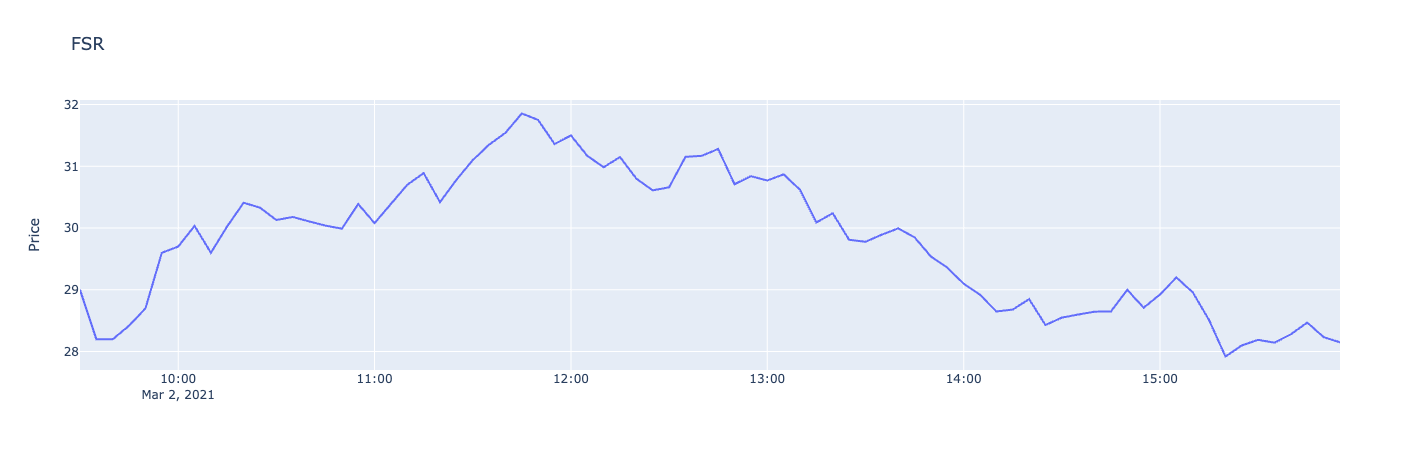

In [569]:
ticker_obj = yf.Ticker('FSR')
ticker_hist = ticker_obj.history(start = '2021-03-02', end = '2021-03-03', interval = '5m')

closing_prices = ticker_hist['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x = ticker_hist.index, y = closing_prices, mode = 'lines', name = 'Close'))



fig.update_layout(title = 'FSR', yaxis_title = 'Price')


fig.show()

In [173]:
#Jeff Individual

jeff_individual = pd.read_csv('Jeff_Individual_Schwab.csv', header=1, skipfooter=1, engine = 'python').drop('Unnamed: 8', axis=1)
jeff_individual['Date'] = pd.to_datetime(jeff_individual['Date'], format = '%m/%d/%Y')
jeff_individual['Price'] = jeff_individual['Price'].apply(lambda x: x.strip()[1:].replace(',', '')).astype(float)
jeff_individual['Action'] = jeff_individual['Action'].apply(lambda x: 'buy' if x == 'Buy' else 'sell')
jeff_individual.columns = ['date', 'side', 'symbol', 'description', 'quantity', 'average_price', 'fees & comm', 'amount']
jeff_individual['amount'] = jeff_individual['amount'].str.replace('[$,()]', '', regex=True).astype('float64')
jeff_individual = jeff_individual.rename(columns = {'amount':'total'}).iloc[::-1].reset_index(drop=True)

jeff_individual.loc[25, 'quantity'], jeff_individual.loc[25, 'average_price'] =  jeff_individual.loc[25, 'quantity']*10, jeff_individual.loc[25, 'average_price']/10

jeff_individual_stocks = et.StocksCrypto(jeff_individual)

jeff_individual_stocks.examine_trades()
jeff_individual_stocks.add_price_diff()


### Short intervals

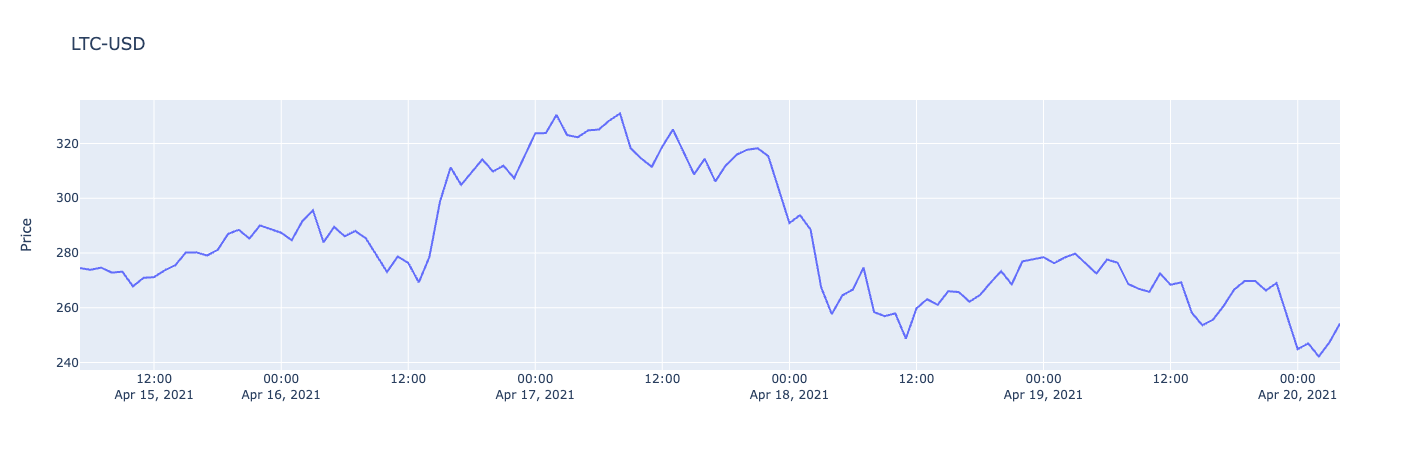

In [16]:
ticker = 'LTC-USD'
ticker_obj = yf.Ticker(ticker)
ticker_hist = ticker_obj.history(start = '2021-04-15', end = '2021-04-20', interval = '1h')

closing_prices = ticker_hist['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x = ticker_hist.index, y = closing_prices, mode = 'lines', name = 'Close'))



fig.update_layout(title = ticker, yaxis_title = 'Price')


fig.show()